In [1]:
import numpy as np
import scipy.io
import scipy.stats
import matplotlib.pyplot as plt
from itertools import combinations
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches

In [2]:
plt.close("all")

load data files

In [3]:
oxy_sub1=scipy.io.loadmat('C:/Users/boton/Documents/Documents/Stony Brook University/2. Semester/BME 502 - Advanced Numerical & Computation Analysis/Final Project\Github repo/fMRI-analysis/oxytocinRSdata/subject1.mat')

llp = oxy_sub1['mts'][0][0] # left lateral parietal cortex
mpfc = oxy_sub1['mts'][1][0] # medial prefrontal cortex
pcc = oxy_sub1['mts'][2][0] # posterior cingulate cortex
rlp = oxy_sub1['mts'][3][0] # right lateral parietal cortex

############# PART 1: Calculate Pearson correlation at different time delays #############

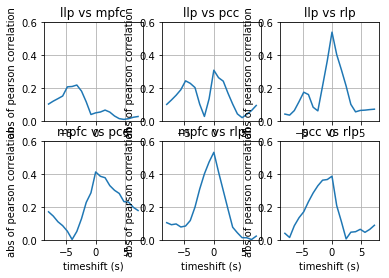

In [4]:
combs = list(combinations([0, 1, 2, 3], 2))
titles = ["llp","mpfc","pcc","rlp"]

max_shift = 10 # 1 increment is 0.8 seconds

pcorrs_sign = np.zeros((len(combs),2*max_shift)) # 2D array for correlation values (with + - sign)
pcorrs = np.zeros((len(combs),2*max_shift)) # 2D array for correlation values (only absolute values)
timeshifts = np.linspace(-max_shift*0.8,max_shift*0.8,2*max_shift,endpoint=False) # x values (in seconds) for graphs
    
fig, axs = plt.subplots(2, 3) # open figure with subplots
    
for i,comb in enumerate(combs): # for all combinations
    ind1 = comb[0] # index of A
    ind2 = comb[1] # index of B
    
    title = titles[ind1] + " vs " + titles[ind2]  # title for graph
    
    x = oxy_sub1['mts'][ind1][0] # timeseries A
    y = oxy_sub1['mts'][ind2][0] # timeseries B
    
    x = x[max_shift:-max_shift] # crop timeseries A
    
    for j in range(2*max_shift): # for each timeshift
        pcorrs_sign[i][j] = scipy.stats.pearsonr(x,y[j:-2*max_shift+j])[0] # calculate correlation for each timeshift
        pcorrs = abs(pcorrs_sign)

    # display
    a = int(i/3) # first coordinate of subplot
    b = i%3 # second coordinate of subplot
   
    axs[a,b].plot(timeshifts, pcorrs[i]) # plot
    axs[a,b].set_title(title)
    axs[a,b].set_xlabel("timeshift (s)")
    axs[a,b].set_ylabel("abs of pearson correlation")
    axs[a,b].grid()
    axs[a,b].set_ylim([0,0.6])

In [6]:
print("negative delay means x delayed compared to y") ###

negative delay means x delayed compared to y


############# PART 2: P(rho) at different rho values (at time delay=0) #############

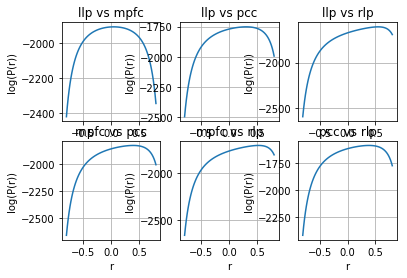

In [9]:
# function for calculation P(r)  
def Posterior(xvals,yvals,r,mx,my,sigx,sigy):
    preexp = 1/(2*np.pi*sigx*sigy*np.sqrt((1-r**2)))
    P_rho = 0  # for log
    for x,y in zip(xvals,yvals):
        z = (x-mx)**2/sigx**2 + (y-my)**2/sigy**2 - 2*r*(x-mx)*(y-my)/(sigx*sigy)
        newP = np.log(preexp * np.exp(-z/(2*(1-r**2))))
        P_rho = P_rho + newP
    return P_rho

r_vals = np.linspace(-0.8,0.8,101) # r values tested

P_r = np.zeros((len(combs),len(r_vals))) # empty array for storing P(r) values

fig, axs = plt.subplots(2, 3) # open figure with subplots
    
for i,comb in enumerate(combs): # for all combinations
    ind1 = comb[0] # index of A
    ind2 = comb[1] # index of B
    
    title = titles[ind1] + " vs " + titles[ind2]  # title for graph
    
    x = oxy_sub1['mts'][ind1][0] # timeseries A
    y = oxy_sub1['mts'][ind2][0] # timeseries B
    
    # inputs for function
    mx = np.mean(x)
    my = np.mean(y)
    sigx = np.std(x)
    sigy = np.std(y)
    
    # call function
    P_r[i] = Posterior(x,y,r_vals,mx,my,sigx,sigy)

    # display
    a = int(i/3) # first coordinate of subplot
    b = i%3 # second coordinate of subplot
   
    axs[a,b].plot(r_vals, P_r[i]) # plot
    axs[a,b].set_title(title)
    axs[a,b].set_xlabel("r")
    axs[a,b].set_ylabel("log(P(r))")
    axs[a,b].grid()

############# PART 3: P(rho) with time delay considered #############

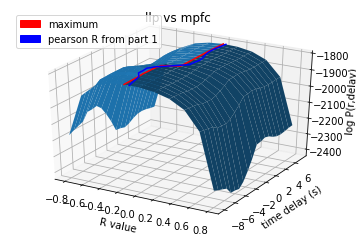

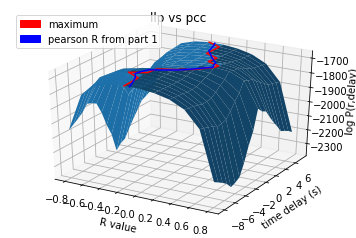

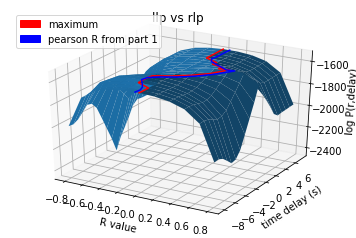

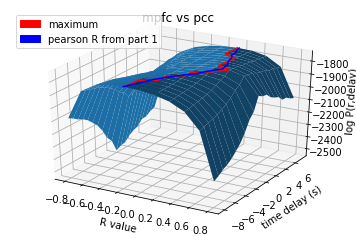

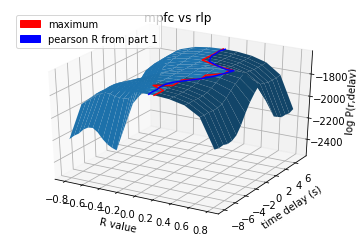

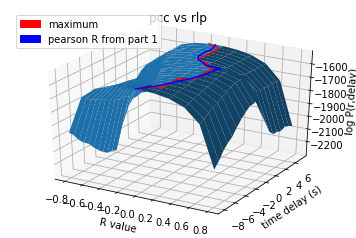

In [12]:
max_shift = 10 # 1 increment is 0.8 seconds
timeshifts = np.linspace(-max_shift*0.8,max_shift*0.8,2*max_shift,endpoint=False) # x values (in seconds) for graphs

r_vals = np.linspace(-0.8,0.8,11) # r values tested

R,S = np.meshgrid(r_vals, timeshifts) # meshgrid for displaying

P_r = np.zeros((len(combs),len(timeshifts),len(r_vals)))  # for storing P(r) values
maxrs = np.zeros((len(combs),len(timeshifts),3)) # for storing max P(r) values

#fig = plt.figure() # if we want everything to be on one figure

for i,comb in enumerate(combs): # for all combinations
    ind1 = comb[0] # index of A
    ind2 = comb[1] # index of B
    
    title = titles[ind1] + " vs " + titles[ind2]  # title for graph
    
    x0 = oxy_sub1['mts'][ind1][0] # timeseries A
    y0 = oxy_sub1['mts'][ind2][0] # timeseries B

    x = x0[max_shift:-max_shift] # crop timeseries A
        
    for j in range(2*max_shift): # for each timeshift
        y = y0[j:-2*max_shift+j] # crop y
        
        # inputs for function
        mx = np.mean(x)
        my = np.mean(y)
        sigx = np.std(x)
        sigy = np.std(y)
        
        # call function
        P_r[i][j] = Posterior(x,y,r_vals,mx,my,sigx,sigy)
        
        # save the maximum
        maxrs[i][j] = [r_vals[P_r[i][j] == max(P_r[i][j])], timeshifts[j], max(P_r[i][j])]  # for each time delay, save the location of the maximum P(r) and its value

    # display
#    ax = fig.add_subplot(2, 3, i+1, projection='3d') # if we want everything to be on one figure      
    
    fig = plt.figure() # if we want a new figure every loop
    ax = fig.add_subplot(111,projection='3d') # if we want a new figure every loop
    
    ax.plot_surface(R,S,P_r[i], antialiased=True) # plot the surface in 3d
    ax.plot(maxrs[i,:,0], maxrs[i,:,1], maxrs[i,:,2], color='r') # plot the maximum P(r) as a line
    ax.plot(pcorrs_sign[i], maxrs[i,:,1], maxrs[i,:,2], color='b') # plot the calculated pearson R from part 2 (at the height of log P(r,delay))
    ax.set_title(title)
    ax.set_xlabel("R value")
    ax.set_ylabel("time delay (s)")
    ax.set_zlabel("log P(r,delay)")
    
    l1 = mpatches.Patch(color='r', label='maximum')
    l2 = mpatches.Patch(color='b', label='pearson R from part 1')

    ax.legend(handles=[l1, l2], loc=2)